# Introduction
This Jupyter notebook (Repressilator.ipynb) contains the code used to generate the following examples for the paper "Analysis of Biochemical Oscillators Using Bond
  Graphs and Linear Control Theory" by Peter Gawthrop and Michael Pan:
  
- 5. The Repressilator

The examples

- 3. Illustrative Example (system Toy)
- 4. The Sel'kov Oscillator (system Selkov)

are in the notebook Oscillation.ipynb

In [1]:
import BondGraphTools as bgt
from BondGraphTools.reaction_builder import Reaction_Network
import numpy as np
import IPython.display as disp
import copy
import scipy.optimize as opt
import scipy.integrate as int

## Control systems package
import control as con
con.config.defaults['xferfcn.display_format'] = 'zpk'

## Stoichiometric analysis
import stoich as st

## BG from stoichiometry
import stoichBondGraph as stbg

# Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Plotting
import matplotlib.pyplot as plt
from cycler import cycler

## For reimporting: use imp.reload(module)
import importlib as imp

## Saving data
import pickle

quiet = True
Original = False
Plotting=False
SavingData = False

In [2]:
## System
SystemName = 'Repressilator'


In [3]:
## Reduced system order
redOrder = 3
largeOrder = 30

In [4]:
## Set up parameters to change
muA_nom_0 = 20
muA_nom = 1.0*muA_nom_0

In [5]:
def zero_crossings(a):
    """Zero crossings from  positive to negative
    """
    return np.where(np.diff(np.sign(a))>0)[0]

In [6]:
def rn2bg(rn,name):
    """ 
    Reaction network to Bond Graph.
    Creates BG file name.py
    Returns basic stoichiometry
    """
    # Extract stoichiometry from reaction network
    Nf_0 = np.array(rn.forward_stoichiometry)
    Nr_0 = np.array(rn.reverse_stoichiometry)
    N_0 = Nr_0 - Nf_0
    
    ## sanity check
    SanityCheck(N_0,rn.stoichiometry)

    ## Species and reactions
    species = rn.species
    n_X = len(species)
    reaction = []
    for Reaction in reactions:
        reaction.append(Reaction[1])
        
    ## Create BG from stoichiometry
    s_0 = {}
    s_0['N'] = N_0
    s_0['Nf'] = Nf_0
    s_0['Nr'] = Nr_0
    s_0['species'] = species
    s_0['n_X'] = len(species)
    s_0['reaction'] = reaction
    s_0['name'] = name
    stbg.model(s_0)

    return s_0

In [7]:
# def SaveFig(SystemName,PlotName,Plotting=True,fontsize=14,linewidth=5):
#     if Plotting:
#         plt.rcParams.update({'font.size': fontsize})
#         plt.rcParams.update({'lines.linewidth': linewidth})
#         plotname = f'Figs/{SystemName}_{PlotName}.pdf'
#         plt.savefig(plotname)

In [8]:
# def SaveFig(SystemName,PlotName,Plotting=True,fontsize=14,linewidth=5):
#     if Plotting:
#         plt.rcParams.update({'font.size': fontsize})
#         plt.rcParams.update({'lines.linewidth': linewidth})
#         plt.rcParams.update({'lines.markersize': 4*linewidth})
#         plotname = f'Figs/{SystemName}_{PlotName}.pdf'
#         plt.savefig(plotname)

In [9]:
def SetPlot(fontsize=14,linewidth=5,RL=False):
        ## Sizes
        plt.rcParams.update({'font.size': fontsize})
        plt.rcParams.update({'lines.linewidth': linewidth})
        plt.rcParams.update({'lines.markersize': 6*linewidth})
 
        ## set up colour cycling for plot
        if RL:
            ## Root locus colors
            default_cycler = (cycler(color=['grey','grey','r', 'g', 'b']))
        else:
            default_cycler = (cycler(color=['r', 'g', 'b']))
        plt.rc('axes', prop_cycle=default_cycler)
    
SetPlot()


In [10]:

def SaveFig(SystemName,PlotName,fontsize=14,linewidth=5,RL=False):
    if Plotting:
        SetPlot(RL=RL)
        plotname = f'Figs/{SystemName}_{PlotName}.pdf'
        plt.tight_layout()
        plt.savefig(plotname)

In [11]:
def step_response(sys,T=None):
    resp = con.step_response(sys,T=T)
    t = resp.t
    y = np.array(resp.y).flatten()
    plt.plot(t,y)
    return y

In [12]:
def impulse_response(sys,T=None):
    resp = con.impulse_response(sys,T=T)
    t = resp.t
    y = np.array(resp.y).flatten()
    plt.plot(t,y)
    return y

In [13]:
def initial_response(sys,T=None,x0=0):
    resp = con.initial_response(sys,T=T,x0=x0)
    t = resp.t
    y = np.array(resp.y).flatten()
    plt.plot(t,y)
    return y

In [14]:
def ExtractSubsystem(Sys,i_in,i_out):
    
    A_sub = Sys.A
    B_sub = Sys.B[:,i_in]
    C_sub = Sys.C[i_out,:]
    D_sub = Sys.D[i_out,i_in]

    return con.minreal(con.ss(A_sub,B_sub,C_sub,D_sub))

In [15]:
def SanityCheck(m_1,m_2):
    err = np.max(abs(np.array(m_1)-np.array(m_2)))
    if not err==0:
        print(f'Warning: sanity check failure. err={err}')

In [16]:
def extractSysdX(Sys,s,chemo,chemostats,outp):
    
    ## Index of output
    species = s['species']
    i_v = species.index(outp)
    
    ## Index of input
    i = chemostats.index(chemo)
  
    sys = con.ss(Sys.A,Sys.B[:,i],Sys.C[i_v,:],Sys.D[i_v,i])
    
    return sys
    
def Lin(s,sc,parameter=None,x_ss=None,chemostats=[],outvar='dX',Inp=['P','E'], Outp=['P','E'],quiet=True):

    ## Linearise
    SYS = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='dX',quiet=quiet)

    # Extract individual transfer functions
    TF = {}
    for inp in Inp:
        for outp in Outp:
            if not quiet:
                print(inp,'-->',outp)
            tf = con.tf(extractSysdX(SYS,s,inp,chemostats,outp))
            TF[f'{inp}_{outp}'] = tf
            if not quiet:
                print(tf)

    return TF

In [17]:
def SteadyState(s,sc,parameter,x0,OutpVar='P3',Last=150,returnAll=False):
    
    t = np.linspace(0,Last,1000)
    ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x0,quiet=True)
    x_ss = ndat['X'][-1,:]
    # st.plot(s,ndat,dX=False,x_ss=x_ss,species=['P1','P2','P3'],reaction=[])
    # st.plot(s,ndat,dX=True,species=[OutpVar],reaction=[])

    ## Flow into P
    species = s['species']
    v_ss = ndat['dX'][-1,species.index(OutpVar)]
    print('v_ss=',v_ss)
    if returnAll:
        SS = {}
        ## Save up all steady-state data
        for key in ndat:
            if not key in ['t']:
#                 print(key)
                SS[key] = ndat[key][-1,:]
        return x_ss,v_ss,SS
    else:
        return x_ss,v_ss

def func(x_P):
    print('***', x_P)
    x0[species.index('P3')] = x_P
    x_ss,v_ss = SteadyState(s,OLsc,parameter,x0,OutpVar='P3')
    return v_ss

def findSteadyState(s,sc,parameter,x0,OutpVar='P3',returnAll=False):
    
    species = s['species']
    root = opt.fsolve(func,x0[species.index(OutpVar)],xtol=1e-3)
    
    x_P_ss = root[0]
    
    x0[species.index(OutpVar)] = x_P_ss
    
    if returnAll:
        x_ss,v_ss,SS = SteadyState(s,sc,parameter,x0,OutpVar=OutpVar,returnAll=returnAll)
        return x_ss,SS
    else:
        x_ss,v_ss = SteadyState(s,sc,parameter,x0,OutpVar=OutpVar,returnAll=returnAll)
        return x_ss,x_P_ss

In [18]:
def IntegrateTF(L0,crite=1e-4):
    L0_tf = con.tf(L0)
    num0 = L0_tf.num[0][0]
    den0 = L0_tf.den[0][0]
#     print(den0)
    ln = len(num0)
    if (abs(num0[ln-1])<crite):
        ## remove s factor in numerator
        num = num0[:ln-1]
        den = den0
    else:
        ## Integrator
        ld = len(den0)
        num = num0
        den = np.zeros(ld+1)  
        den[:ld] = den0

    L = con.tf(num,den)
    return L

# Define Model as Reaction Network and Create BondGraphTools Model 

Define model

In [19]:
reactions = [
    ("A + G1_E = G1_EA", "G1_Tc1"),
    ("G1_EA = G1_E + G1_M", "G1_Tc2"),
    ("G1_E + 2*P2 = G1_EI", "G1_Tc3"),
    ("G1_EA + 2*P2 = G1_EAI", "G1_Tc4"),
    ("G1_M + R = G1_C0", "G1_rb"),
    ("G1_C0 + A = G1_C1 + G1_M", "G1_r1"),
    ("G1_C1 + A = G1_C2", "G1_r2"),
    ("G1_C2 + A = G1_C3", "G1_r3"),
    ("G1_C3 + A = G1_C4", "G1_r4"),
    ("G1_C4 + A = G1_C5", "G1_r5"),
    ("G1_C5 + A = G1_C6", "G1_r6"),
    ("G1_C6 + A = G1_C7", "G1_r7"),
    ("G1_C7 + A = G1_C8", "G1_r8"),
    ("G1_C8 = R + P1", "G1_rt"),
    ("G1_M = G1_XM", "G1_degM"),
    ("P1 = G1_XP", "G1_degP"),

    ("A + G2_E = G2_EA", "G2_Tc1"),
    ("G2_EA = G2_E + G2_M", "G2_Tc2"),
    ("G2_E + 2*P3 = G2_EI", "G2_Tc3"),
    ("G2_EA + 2*P3 = G2_EAI", "G2_Tc4"),
    ("G2_M + R = G2_C0", "G2_rb"),
    ("G2_C0 + A = G2_C1 + G2_M", "G2_r1"),
    ("G2_C1 + A = G2_C2", "G2_r2"),
    ("G2_C2 + A = G2_C3", "G2_r3"),
    ("G2_C3 + A = G2_C4", "G2_r4"),
    ("G2_C4 + A = G2_C5", "G2_r5"),
    ("G2_C5 + A = G2_C6", "G2_r6"),
    ("G2_C6 + A = G2_C7", "G2_r7"),
    ("G2_C7 + A = G2_C8", "G2_r8"),
    ("G2_C8 = R + P2", "G2_rt"),
    ("G2_M = G2_XM", "G2_degM"),
    ("P2 = G2_XP", "G2_degP"),

    ("A + G3_E = G3_EA", "G3_Tc1"),
    ("G3_EA = G3_E + G3_M", "G3_Tc2"),
    ("G3_E + 2*P1 = G3_EI", "G3_Tc3"),
    ("G3_EA + 2*P1 = G3_EAI", "G3_Tc4"),
    ("G3_M + R = G3_C0", "G3_rb"),
    ("G3_C0 + A = G3_C1 + G3_M", "G3_r1"),
    ("G3_C1 + A = G3_C2", "G3_r2"),
    ("G3_C2 + A = G3_C3", "G3_r3"),
    ("G3_C3 + A = G3_C4", "G3_r4"),
    ("G3_C4 + A = G3_C5", "G3_r5"),
    ("G3_C5 + A = G3_C6", "G3_r6"),
    ("G3_C6 + A = G3_C7", "G3_r7"),
    ("G3_C7 + A = G3_C8", "G3_r8"),
    ("G3_C8 = R + P3", "G3_rt"),
    ("G3_M = G3_XM", "G3_degM"),
    ("P3 = G3_XP", "G3_degP"),
]

rn = Reaction_Network(name="RepressilatorFB")
for (reaction_string,reaction_name) in reactions:
    rn.add_reaction(reaction_string, name=reaction_name)

rn.add_chemostat("A")
rn.add_chemostat("G1_XM")
rn.add_chemostat("G1_XP")
rn.add_chemostat("G2_XM")
rn.add_chemostat("G2_XP")
rn.add_chemostat("G3_XM")
rn.add_chemostat("G3_XP")

if not Original:
    chemostats = ['A', 'G1_XM', 'G1_XP', 'G2_XM','G2_XP','G3_XM','G3_XP']


In [20]:
if Original: # Use Michaels original version
    model = rn.as_network_model(normalised=True)
else:  # Use the stoichiometric aproach to build model
    s0 = rn2bg(rn,'RepressilatorFB_abg')
    species = s0['species']
    reaction = s0 ['reaction']
    n_X = s0['n_X']
    
    import RepressilatorFB_abg as sys_abg
    model = sys_abg.model()


Set parameters

In [21]:
n = 8
alpha = np.exp(1.25)
mu_folding = 20.0
KP = alpha**n/np.exp(mu_folding)
mu0_P = n*np.log(alpha) - mu_folding
A_nom=5800000
# muA_nom=20
Kd = 30
h = 2

# Calculate thermodynamic constant from amount and chemical potential
def compute_K(x, mu):
    return (1 / x) * np.exp(mu)

# Thermodynamic constants
KR = 1.0
KM = 1.0
(model/"C:G1_M").set_param("k",KM)
(model/"C:G2_M").set_param("k",KM)
(model/"C:G3_M").set_param("k",KM)

# Transcription
w = 4.14
theta = 4.38
K_A = compute_K(A_nom, muA_nom)
r_Tc = w / (K_A * theta)
RbA = K_A * theta
RbM = 1e6
RbI = (100*KP)**h #Kd*mu0_P
r2 = (1+RbA/RbM)*r_Tc
r1 = r2*RbM/RbA
KE = 1
KEA = KE*RbA*r1/(r1+r2)
KEI = RbI*KE*KP
KEAI = RbI*KEA*KP
r3 = 1e6
r4 = 1e6
(rTc1, rTc2, rTc3, rTc4) = (r1, r2, r3, r4)

(model/"C:G1_E").set_param("k",KE)
(model/"C:G1_EA").set_param("k",KEA)
(model/"C:G1_EI").set_param("k",KEI)
(model/"C:G1_EAI").set_param("k",KEAI)
(model/"R:G1_Tc1").set_param("r",r1)
(model/"R:G1_Tc2").set_param("r",r2)
(model/"R:G1_Tc3").set_param("r",r3)
(model/"R:G1_Tc4").set_param("r",r4)

(model/"C:G2_E").set_param("k",KE)
(model/"C:G2_EA").set_param("k",KEA)
(model/"C:G2_EI").set_param("k",KEI)
(model/"C:G2_EAI").set_param("k",KEAI)
(model/"R:G2_Tc1").set_param("r",r1)
(model/"R:G2_Tc2").set_param("r",r2)
(model/"R:G2_Tc3").set_param("r",r3)
(model/"R:G2_Tc4").set_param("r",r4)

(model/"C:G3_E").set_param("k",KE)
(model/"C:G3_EA").set_param("k",KEA)
(model/"C:G3_EI").set_param("k",KEI)
(model/"C:G3_EAI").set_param("k",KEAI)
(model/"R:G3_Tc1").set_param("r",r1)
(model/"R:G3_Tc2").set_param("r",r2)
(model/"R:G3_Tc3").set_param("r",r3)
(model/"R:G3_Tc4").set_param("r",r4)

# Translation



γ_max = 1260
kf = 4 * γ_max  # Multiplied by 4 to account for 4 ATP molecules per amino acid
KC0 = 1.0
(model/"C:G1_C0").set_param("k",KC0)
(model/"C:G2_C0").set_param("k",KC0)
(model/"C:G3_C0").set_param("k",KC0)
KC1 = alpha
(model/"C:G1_C1").set_param("k",KC1)
(model/"C:G2_C1").set_param("k",KC1)
(model/"C:G3_C1").set_param("k",KC1)
r1 = kf/np.exp(muA_nom)
(model/"R:G1_r1").set_param("r",r1)
(model/"R:G2_r1").set_param("r",r1)
(model/"R:G3_r1").set_param("r",r1)

for i in range(2, n+1):
    KCi = alpha**i
    (model/f"C:G1_C{i}").set_param("k",KCi)
    (model/f"C:G2_C{i}").set_param("k",KCi)
    (model/f"C:G3_C{i}").set_param("k",KCi)
    ri = kf/np.exp(muA_nom)/(alpha**(i-1))
    (model/f"R:G1_r{i}").set_param("r",ri)
    (model/f"R:G2_r{i}").set_param("r",ri)
    (model/f"R:G3_r{i}").set_param("r",ri)

rd = 100 * kf/(alpha**n)
(model/"R:G1_rt").set_param("r",rd)
(model/"R:G2_rt").set_param("r",rd)
(model/"R:G3_rt").set_param("r",rd)
rb = 1e-2
(model/"R:G1_rb").set_param("r",rb)
(model/"R:G2_rb").set_param("r",rb)
(model/"R:G3_rb").set_param("r",rb)

# Degradation
rdegM = np.log(2)/2
(model/"R:G1_degM").set_param("r",rdegM)
(model/"R:G2_degM").set_param("r",rdegM)
(model/"R:G3_degM").set_param("r",rdegM)

rdegP = np.log(2)/4/KP
(model/"R:G1_degP").set_param("r",rdegP)
(model/"R:G2_degP").set_param("r",rdegP)
(model/"R:G3_degP").set_param("r",rdegP)

(model/"C:R").set_param("k",1.0)
(model/"C:P1").set_param("k",KP)
(model/"C:P2").set_param("k",KP)
(model/"C:P3").set_param("k",KP)


In [22]:
## Set chemostats
Large = 1e6
print(muA_nom)
mu_XM = np.log(1e-6)
mu_XP = np.log(1e-10)

if Original:
    (model/"SS:A").set_param("e",muA_nom)
    
    (model/"SS:G1_XM").set_param("e",mu_XM)
    (model/"SS:G2_XM").set_param("e",mu_XM)
    (model/"SS:G3_XM").set_param("e",mu_XM)
    
    (model/"SS:G1_XP").set_param("e",mu_XP)
    (model/"SS:G2_XP").set_param("e",mu_XP)
    (model/"SS:G3_XP").set_param("e",mu_XP)



else:
    (model/"C:A").set_param("k",np.exp(muA_nom)/Large)
    
    (model/"C:G1_XM").set_param("k",np.exp(mu_XM)/Large)
    (model/"C:G2_XM").set_param("k",np.exp(mu_XM)/Large)
    (model/"C:G3_XM").set_param("k",np.exp(mu_XM)/Large)
    
    (model/"C:G1_XP").set_param("k",np.exp(mu_XP)/Large)
    (model/"C:G2_XP").set_param("k",np.exp(mu_XP)/Large)
    (model/"C:G3_XP").set_param("k",np.exp(mu_XP)/Large)

20.0


#  Set parameters

In [23]:
def SetParameter(Unit=False):
    parameter = {}
    for spec in species:
        comp = 'C:'+spec
        val = (model/comp).params['k']['value']
        if Unit:
            val=1
        if spec in chemostats:
    #         print('chemostat')
            # val = np.exp(val)
            print(f'Chemostat {spec}: {val:.2e}')
            if Unit:
                val=1
    #     print(f'{spec} \t{val:.2e}')
        name = f'K_{spec}'
        parameter[name] = val


    for reac in reaction:
        comp = 'R:'+reac
        val = (model/comp).params['r']['value']
        if Unit:
            val=1
    #     print(f'{reac} \t{val:.2e}')
        name = f'kappa_{reac}'
        parameter[name] = val
    
    return parameter

parameter = SetParameter()



Chemostat A: 4.85e+02
Chemostat G1_XM: 1.00e-12
Chemostat G1_XP: 1.00e-16
Chemostat G2_XM: 1.00e-12
Chemostat G2_XP: 1.00e-16
Chemostat G3_XM: 1.00e-12
Chemostat G3_XP: 1.00e-16


In [24]:
## Write parameters to a function
f = open('SetParameterRepressilator.py','w')
chars = f.write('def SetParameterRepressilator():\n')
for key in parameter:
    str = f"parameter['{key}'] = {parameter[key]}\n"
#     print(str)
    chars = f.write(str)
f.close()

In [25]:
# model.constitutive_relations

# List of Parameters


In [26]:
for par in parameter:
    print(f'{par} = {parameter[par]:.4g}')

K_A = 485.2
K_G1_E = 1
K_G1_EA = 366.2
K_G1_M = 1
K_P2 = 4.54e-05
K_G1_EI = 9.358e-10
K_G1_EAI = 3.427e-07
K_R = 1
K_G1_C0 = 1
K_G1_C1 = 3.49
K_G1_C2 = 12.18
K_G1_C3 = 42.52
K_G1_C4 = 148.4
K_G1_C5 = 518
K_G1_C6 = 1808
K_G1_C7 = 6311
K_G1_C8 = 2.203e+04
K_P1 = 4.54e-05
K_G1_XM = 1e-12
K_G1_XP = 1e-16
K_G2_E = 1
K_G2_EA = 366.2
K_G2_M = 1
K_P3 = 4.54e-05
K_G2_EI = 9.358e-10
K_G2_EAI = 3.427e-07
K_G2_C0 = 1
K_G2_C1 = 3.49
K_G2_C2 = 12.18
K_G2_C3 = 42.52
K_G2_C4 = 148.4
K_G2_C5 = 518
K_G2_C6 = 1808
K_G2_C7 = 6311
K_G2_C8 = 2.203e+04
K_G2_XM = 1e-12
K_G2_XP = 1e-16
K_G3_E = 1
K_G3_EA = 366.2
K_G3_M = 1
K_G3_EI = 9.358e-10
K_G3_EAI = 3.427e-07
K_G3_C0 = 1
K_G3_C1 = 3.49
K_G3_C2 = 12.18
K_G3_C3 = 42.52
K_G3_C4 = 148.4
K_G3_C5 = 518
K_G3_C6 = 1808
K_G3_C7 = 6311
K_G3_C8 = 2.203e+04
K_G3_XM = 1e-12
K_G3_XP = 1e-16
kappa_G1_Tc1 = 30.85
kappa_G1_Tc2 = 0.0113
kappa_G1_Tc3 = 1e+06
kappa_G1_Tc4 = 1e+06
kappa_G1_rb = 0.01
kappa_G1_r1 = 1.039e-05
kappa_G1_r2 = 2.976e-06
kappa_G1_r3 = 8.527e-07
kappa_

# Set initial conditions

In [27]:
# model.state_vars

In [28]:
def SetState(n_X):

    X0 = np.ones(n_X)
    small = 1e-6

    X0[species.index('G1_E')] =   0.25
    X0[species.index('G1_EA')] =   0.25
    X0[species.index('G1_M')] =   small
    X0[species.index('P2')] =   100.0
    X0[species.index('G1_EI')] =   0.25
    X0[species.index('G1_EAI')] =   0.25
    X0[species.index('R')] =   5000.0
    X0[species.index('G1_C0')] =   small
    X0[species.index('G1_C1')] =   small
    X0[species.index('G1_C2')] =   small
    X0[species.index('G1_C3')] =   small
    X0[species.index('G1_C4')] =   small
    X0[species.index('G1_C5')] =   small
    X0[species.index('G1_C6')] =   small
    X0[species.index('G1_C7')] =   small
    X0[species.index('G1_C8')] =   small
    X0[species.index('P1')] =   100.0
    X0[species.index('G2_E')] =   0.25
    X0[species.index('G2_EA')] =   0.25
    X0[species.index('G2_M')] =   small
    X0[species.index('P3')] =   1000.0
    X0[species.index('G2_EI')] =   0.25
    X0[species.index('G2_EAI')] =   0.25
    X0[species.index('G2_C0')] =   small
    X0[species.index('G2_C1')] =   small
    X0[species.index('G2_C2')] =   small
    X0[species.index('G2_C3')] =   small
    X0[species.index('G2_C4')] =   small
    X0[species.index('G2_C5')] =   small
    X0[species.index('G2_C6')] =   small
    X0[species.index('G2_C7')] =   small
    X0[species.index('G2_C8')] =   small
    X0[species.index('G3_E')] =   0.25
    X0[species.index('G3_EA')] =   0.25
    X0[species.index('G3_M')] =   small
    X0[species.index('G3_EI')] =   0.25
    X0[species.index('G3_EAI')] =   0.25
    X0[species.index('G3_C0')] =   small
    X0[species.index('G3_C1')] =   small
    X0[species.index('G3_C2')] =   small
    X0[species.index('G3_C3')] =   small
    X0[species.index('G3_C4')] =   small
    X0[species.index('G3_C5')] =   small
    X0[species.index('G3_C6')] =   small
    X0[species.index('G3_C7')] =   small
    X0[species.index('G3_C8')] =   small

    ## Reset chemostat states with large state so that ln Kx = mu
    for chem in chemostats:
        print('Resetting chemostat:', chem, ' to', Large)
        X0[species.index(chem)] = Large

    return X0


In [29]:
if Original:
    x0 = np.array([
       0.25,  #C: G1_E
       0.25,  #C: G1_EA
       1e-6,  #C: G1_M
       100.0,  #C: P2
       0.25,  #C: G1_EI
       0.25,  #C: G1_EAI
       5000.0,  #C: R
       1e-6,  #C: G1_C0
       1e-6,  #C: G1_C1
       1e-6,  #C: G1_C2
       1e-6,  #C: G1_C3
       1e-6,  #C: G1_C4
       1e-6,  #C: G1_C5
       1e-6,  #C: G1_C6
       1e-6,  #C: G1_C7
       1e-6,  #C: G1_C8
       100.0,  #C: P1
       0.25,  #C: G2_E
       0.25,  #C: G2_EA,
       1e-6,  #C: G2_M,
       1000.0,  #C: P3
       0.25,  #C: G2_EI
       0.25,  #C: G2_EAI
       1e-6,  #C: G2_C0
       1e-6,  #C: G2_C1
       1e-6,  #C: G2_C2
       1e-6,  #C: G2_C3
       1e-6,  #C: G2_C4
       1e-6,  #C: G2_C5
       1e-6,  #C: G2_C6
       1e-6,  #C: G2_C7
       1e-6,  #C: G2_C8
       0.25,  #C: G3_E
       0.25,  #C: G3_EA
       1e-6,  #C: G3_M
       0.25,  #C: G3_EI
       0.25,  #C: G3_EAI
       1e-6,  #C: G3_C0
       1e-6,  #C: G3_C1
       1e-6,  #C: G3_C2
       1e-6,  #C: G3_C3
       1e-6,  #C: G3_C4
       1e-6,  #C: G3_C5
       1e-6,  #C: G3_C6
       1e-6,  #C: G3_C7
       1e-6,  #C: G3_C8
    ])
else:
    x0 = SetState(n_X)


Resetting chemostat: A  to 1000000.0
Resetting chemostat: G1_XM  to 1000000.0
Resetting chemostat: G1_XP  to 1000000.0
Resetting chemostat: G2_XM  to 1000000.0
Resetting chemostat: G2_XP  to 1000000.0
Resetting chemostat: G3_XM  to 1000000.0
Resetting chemostat: G3_XP  to 1000000.0


# Simulate

In [30]:
timespan = [0.0, 500.0]
t, x = bgt.simulate(model, timespan=timespan, x0=x0, dt=1e-3)

<Figure size 640x480 with 0 Axes>

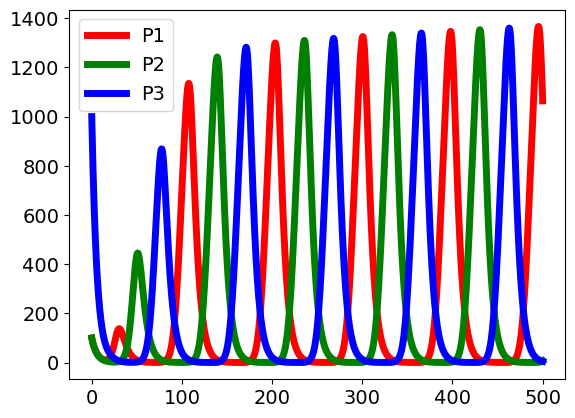

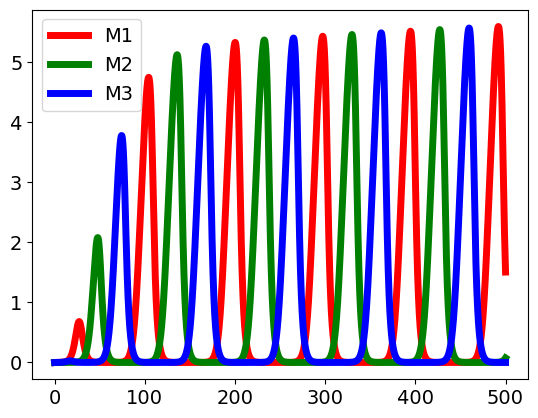

In [31]:
# Protein amounts
from matplotlib import pyplot as plt
plt.figure()
## Proteins
iP = [species.index('P1'), species.index('P2'), species.index('P3')]
## mRNA
iM = [species.index('G1_M'),species.index('G2_M'),species.index('G3_M')]
plt.plot(t,x[:,iP])
plt.legend(['P1','P2','P3'])
plt.show()
plt.plot(t,x[:,iM])
plt.legend(['M1','M2','M3'])
plt.show()

In [32]:
# # mRNA amounts
# plt.figure()
# plt.plot(t,x[:,[2,19,34]])
# plt.show()

Text(0.5, 0, '$mRNA_1$')

Text(0, 0.5, '$P_1$')

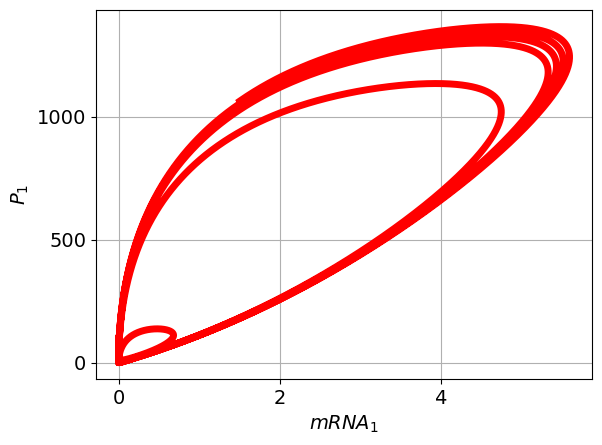

In [33]:
plt.plot(x[:,iM[0]],x[:,iP[0]])
# plt.plot(x_ss[iM[0]],x_ss[iP[0]],marker='+')
plt.locator_params(nbins=4)
plt.grid()
plt.xlabel('$mRNA_1$')
plt.ylabel('$P_1$')
# SaveFig(SystemName,'PhasePlane')

# Redo with stoichiometric approach

In [34]:
if not Original:
## Recreate stoichiometry
    s = st.stoich(sys_abg.model(),quiet=quiet)
    N = s['N']
    Nf = s['Nf']
    Nr = s['Nr']
    
    ## Sanity check
    SanityCheck(N,s0['N'])
    SanityCheck(Nf,s0['Nf'])
    SanityCheck(Nr,s0['Nr'])


In [35]:
## Chemostats
if not Original:
    sc = st.statify(s,chemostats=chemostats)


# Save data - for use in Supplementary.ipynb

In [36]:
if SavingData:
    ## Save data
    SavedData = {}
    StoichData = {}
    StoichData['s'] = s
    StoichData['sc'] = sc
    StoichData['parameter'] = parameter
    SavedData['Stoich'] = StoichData

    SysName = 'Repressilator'
    file = open(f'{SysName}.dat', 'wb')
    pickle.dump(SavedData, file)
    file.close()

# List of Reactions

In [37]:
## Reactions
disp.Latex(st.sprintrl(s,chemformula=False,split=10,all=True))

<IPython.core.display.Latex object>

# List of Flows $v$ as Function of States $x$

In [38]:
## Flows
disp.Latex(st.sprintvl(s))

<IPython.core.display.Latex object>

# List of State $x$ Derivatives as Function of Flows $v$.

In [39]:
## State equations
imp.reload(st)
eqns = st.sprintdxl(s,sc)
disp.Latex(eqns)

<module 'stoich' from '/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py'>

<IPython.core.display.Latex object>

# Simulate (using stoichiometric approach)

In [40]:
if not Original:


    ## Simulate
    tt = np.linspace(0,250,10000)
    ndat = st.sim(s,sc,reduced=False,t=tt,X0=x0,parameter=parameter,quiet=True)


In [41]:
## Sizes
species = s['species']
print(f'Number of species = {len(species)} of which {len(chemostats)} are chemostats giving {len(species)-len(chemostats)} states.')

Number of species = 53 of which 7 are chemostats giving 46 states.


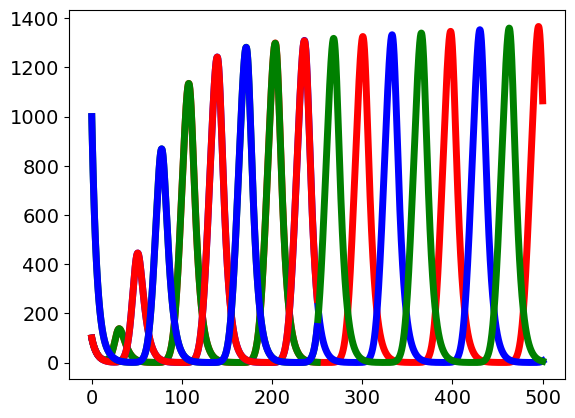

In [42]:
# Protein amounts
iP = [species.index('P1'), species.index('P2'), species.index('P3')]
for i in iP:
    plt.plot(t,x[:,i])
    plt.plot(tt,ndat['X'][:,i])
    
plt.show()


In [43]:
# st.plot(s,ndat,species = ['P1'],reaction = [])
# st.plot(s,ndat,species = ['P2'],reaction = [])
# st.plot(s,ndat,species = ['P3'],reaction = [])
# print(species.index('P3'))

# Power

In [44]:
P_Re = ndat['P_Re']
P_C = -ndat['P_C']
i_chemo = []
for chemo in chemostats:
    i_chemo.append(species.index(chemo))

free = list(set(species)-set(chemostats))
print(free)
i_free = []
for fr in free:
    i_free.append(species.index(fr))
    
P_chemo = P_C[:,i_chemo]
P_free = P_C[:,i_free]

## Total power
PP_Re = np.sum(P_Re,axis=1)
PP_C = np.sum(P_C,axis=1)
PP_chemo = np.sum(P_chemo,axis=1)
PP_free = np.sum(P_free,axis=1)


['G3_C2', 'G3_C7', 'G1_E', 'G1_EA', 'G3_C4', 'G1_C2', 'G2_EI', 'G1_EAI', 'P1', 'G1_C0', 'G2_C6', 'G3_C5', 'G3_C8', 'G2_E', 'G1_C5', 'G2_C2', 'G3_C3', 'G2_EA', 'G1_EI', 'G1_C7', 'G1_C1', 'G2_C1', 'G3_E', 'G3_EAI', 'G3_EI', 'G1_M', 'G1_C3', 'P2', 'G3_EA', 'G1_C6', 'R', 'G2_C5', 'G2_C4', 'G3_C0', 'G1_C4', 'G2_C8', 'P3', 'G2_C3', 'G3_C1', 'G3_C6', 'G2_EAI', 'G2_C0', 'G3_M', 'G1_C8', 'G2_M', 'G2_C7']


[0.00000000e+00 2.50025003e-02 5.00050005e-02 ... 2.49949995e+02
 2.49974997e+02 2.50000000e+02]
4 0.1000100010001
[1.00010001e-01 1.25012501e-01 1.50015002e-01 ... 2.49949995e+02
 2.49974997e+02 2.50000000e+02]


Text(0.5, 0, '$t$')

Text(0, 0.5, '$p/kT$')

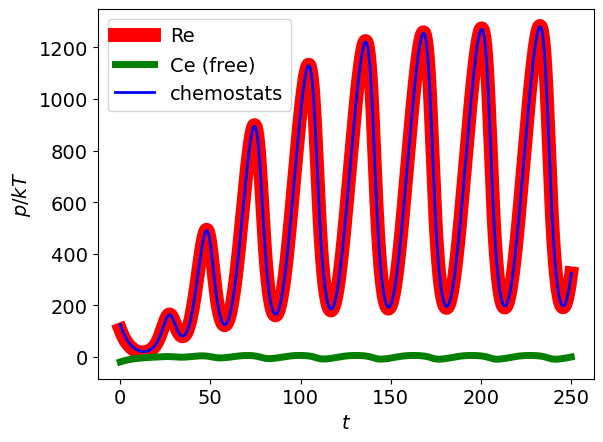

In [45]:
t = ndat['t']
print(t)
t0 = 0.1
i0, = np.where(np.isclose(t, t0,atol=(t[1]-t[0])/2))[0]
print(i0,t[i0])
print(t[i0:])
plt.plot(t[i0:],PP_Re[i0:],label='Re',lw=10)
plt.plot(t[i0:],PP_free[i0:],label='Ce (free)',lw=5)
plt.plot(t[i0:],PP_chemo[i0:],label='chemostats',lw=2)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$p/kT$')

SaveFig(SystemName,'Power')

In [46]:
t0 = 100
i0, = np.where(np.isclose(t, t0,atol=(t[1]-t[0])/2))[0]
print(i0,t[i0])

4000 100.0100010001


In [47]:
imp.reload(st)
kT =st.kT()
print(f'{kT*1e21:.4} zJ')

<module 'stoich' from '/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py'>

4.282 zJ


# Steady state

In [48]:
##Fix P3
OLchemostats = copy.copy(chemostats) 
OLchemostats.append('P3')
print(OLchemostats)
OLsc = st.statify(s,chemostats=OLchemostats)

## Guess a vaue for x_P3 to give zero flow
guess = 10.75855
# Guess = guess+0.0001*np.linspace(-1,1,5)
Guess = [guess]
print(Guess)
i3 = species.index('P3')

for g in Guess:
    x0[i3] = g
    
    ## OL simulate
    OLndat = st.sim(s,OLsc,reduced=False,t=tt,X0=x0,parameter=parameter,quiet=True)
    dXP3 = OLndat['dX'][:,i3]
    v_ss = dXP3[-1]
    x_ss = OLndat['X'][-1,:]
    print('guess',g, ': v_ss',v_ss)

# print(x_ss)
print(species)

['A', 'G1_XM', 'G1_XP', 'G2_XM', 'G2_XP', 'G3_XM', 'G3_XP', 'P3']
[10.75855]
guess 10.75855 : v_ss -1.3583868704980517e-05
['A', 'G1_E', 'G1_EA', 'G1_M', 'P2', 'G1_EI', 'G1_EAI', 'R', 'G1_C0', 'G1_C1', 'G1_C2', 'G1_C3', 'G1_C4', 'G1_C5', 'G1_C6', 'G1_C7', 'G1_C8', 'P1', 'G1_XM', 'G1_XP', 'G2_E', 'G2_EA', 'G2_M', 'P3', 'G2_EI', 'G2_EAI', 'G2_C0', 'G2_C1', 'G2_C2', 'G2_C3', 'G2_C4', 'G2_C5', 'G2_C6', 'G2_C7', 'G2_C8', 'G2_XM', 'G2_XP', 'G3_E', 'G3_EA', 'G3_M', 'G3_EI', 'G3_EAI', 'G3_C0', 'G3_C1', 'G3_C2', 'G3_C3', 'G3_C4', 'G3_C5', 'G3_C6', 'G3_C7', 'G3_C8', 'G3_XM', 'G3_XP']


In [49]:
# for i,spec in enumerate(species):
#     print(f"x_ss[species.index('{spec}')] = {x_ss[i]}")

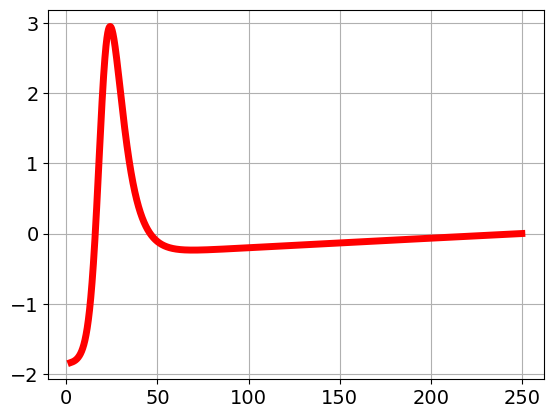

In [50]:

plt.plot(tt[100:],dXP3[100:])
plt.grid()

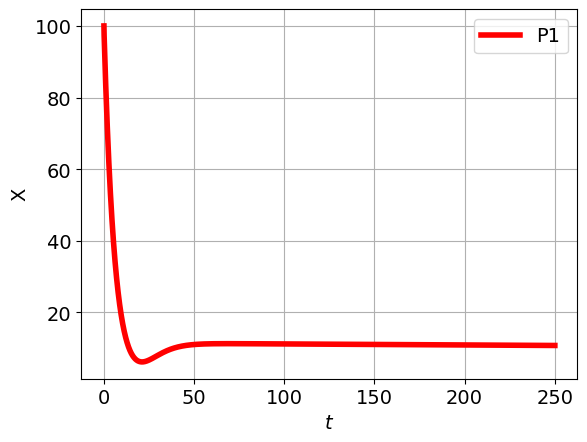

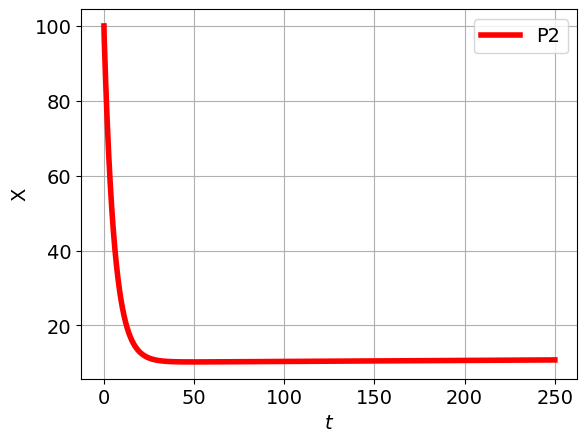

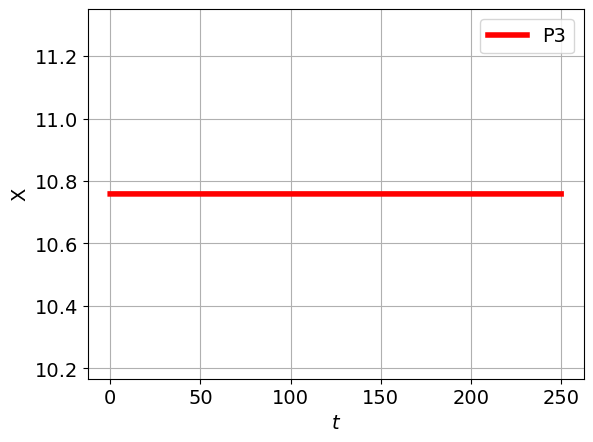

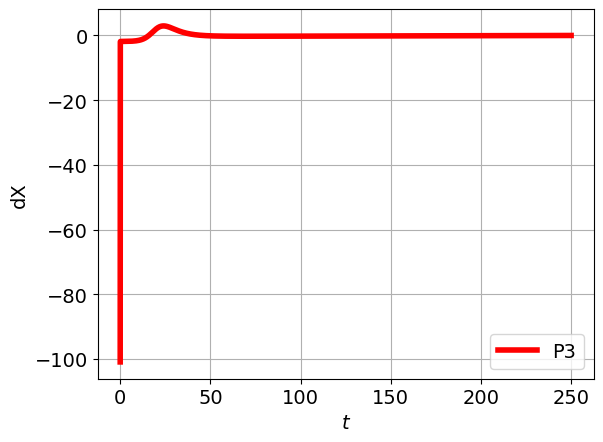

In [51]:
st.plot(s,OLndat,species = ['P1'],reaction = [])
st.plot(s,OLndat,species = ['P2'],reaction = [])
st.plot(s,OLndat,species = ['P3'],reaction = [])
st.plot(s,OLndat,dX=True,species = ['P3'],reaction=[])

In [52]:
## Refine
# x_ss,v_ss = SteadyState(s,OLsc,parameter,x0=x_ss)
# print(v_ss)
# x_ss,v_ss=findSteadyState(s,OLsc,parameter,x0)


Text(0.5, 0, '$mRNA_1$')

Text(0, 0.5, '$P_1$')

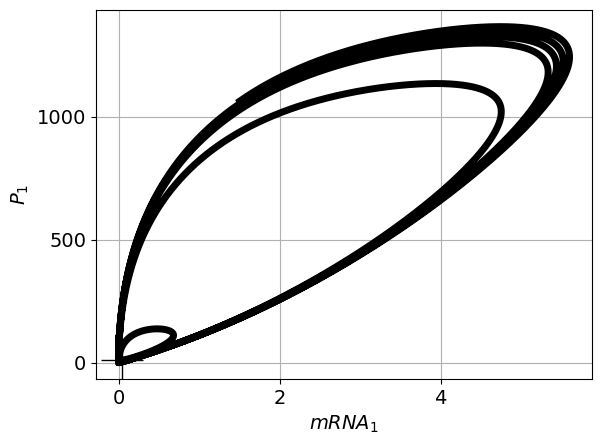

In [53]:
## replot with x_ss
plt.plot(x[:,iM[0]],x[:,iP[0]],color='black')
plt.plot(x_ss[iM[0]],x_ss[iP[0]],marker='+',color='black')
plt.locator_params(nbins=4)
plt.grid()
plt.xlabel('$mRNA_1$')
plt.ylabel('$P_1$')
SaveFig(SystemName,'PhasePlane')

In [54]:
## Simulate from steady-state - just to check ...
ttt = np.linspace(0,100)
OLndat_ss = st.sim(s,OLsc,reduced=False,t=ttt,X0=x_ss,parameter=parameter,quiet=True)

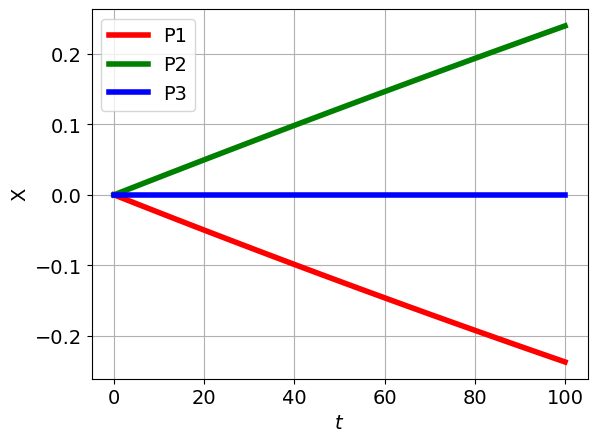

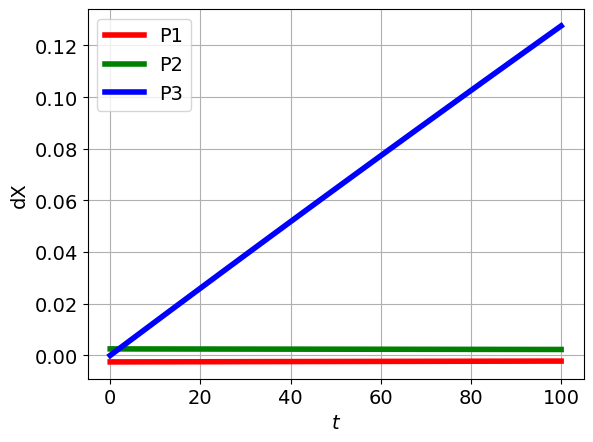

In [55]:
st.plot(s,OLndat_ss,x_ss=x_ss,species=['P1','P2','P3'],reaction=[])
st.plot(s,OLndat_ss,dX=True,species=['P1','P2','P3'],reaction=[])

# Simulate from perturbed steady-state

In [56]:
timespan = [0.0, 500.0]
t_sim, x = bgt.simulate(model, timespan=timespan, x0=x0, dt=1e-3)

<Figure size 640x480 with 0 Axes>

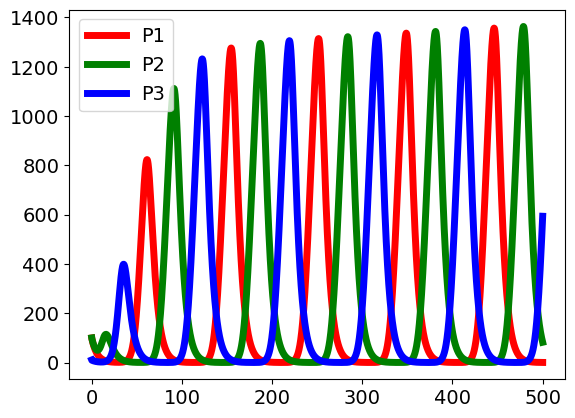

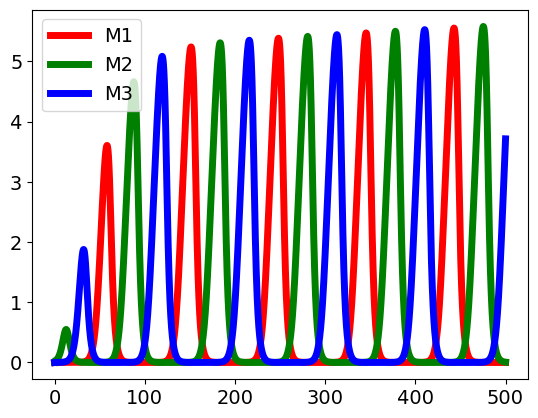

In [57]:
# Protein amounts
plt.figure()
## Proteins
iP = [species.index('P1'), species.index('P2'), species.index('P3')]
## mRNA
iM = [species.index('G1_M'),species.index('G2_M'),species.index('G3_M')]
plt.plot(t_sim,x[:,iP])
plt.legend(['P1','P2','P3'])
plt.show()
plt.plot(t_sim,x[:,iM])
plt.legend(['M1','M2','M3'])
plt.show()

Text(0.5, 0, '$mRNA_1$')

Text(0, 0.5, '$P_1$')

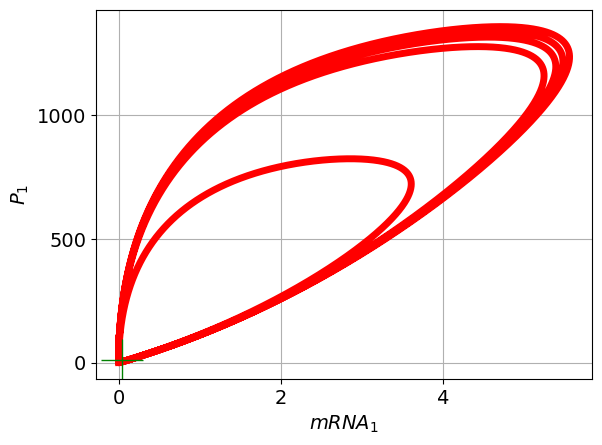

In [58]:
plt.plot(x[:,iM[0]],x[:,iP[0]])
plt.grid()
plt.xlabel('$mRNA_1$')
plt.ylabel('$P_1$')
plt.plot(x_ss[iM[0]],x_ss[iP[0]],marker='+')
plt.locator_params(nbins=4)

# SaveFig(SystemName,'PhasePlane')

# Linearise

In [59]:
Sys = st.lin(s,OLsc,parameter=parameter,x_ss=x_ss,outvar='dX',quiet=True)

3 states have been removed from the model
3 states have been removed from the model
L0_r:


/home/peterg/anaconda3/envs/bgt/lib/python3.8/site-packages/slycot/exceptions.py:241: SlycotResultWarning: 
The selected order 30 is greater
than the order of a minimal realization of the
given system. `nr` was set automatically to 15
corresponding to the order of a minimal realization
of the system
  warn(globals()[warning](fmessage, iwarn, info))


TransferFunction(array([ 5.46926552e+00,  1.38647397e+05, -1.63898946e+04,  8.32811284e+03]), array([1.00000000e+00, 5.03993084e+05, 8.27918870e+04, 5.48835210e+03]))

Pole:-5.04e+05+0.00e+00j	 Zero:-2.54e+04+0.00e+00j
Pole:-8.21e-02+6.44e-02j	 Zero:5.91e-02+2.38e-01j
Pole:-8.21e-02-6.44e-02j	 Zero:5.91e-02-2.38e-01j
F0_r:


TransferFunction(array([9.39569590e-01, 1.19311008e+03, 2.53778217e+05]), array([1.00000000e+00, 5.05460493e+05, 4.90128976e+08, 6.49856380e+11]))

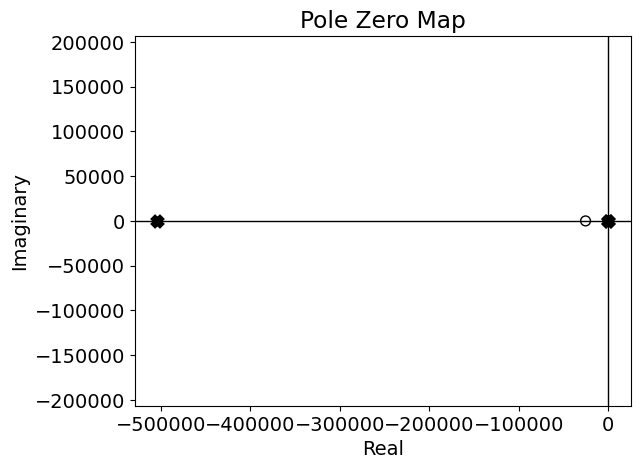

In [60]:
## TF from x_P to dx_P
sys = ExtractSubsystem(Sys,OLchemostats.index('P3'),species.index('P3'))
L0 = -sys

## Tf from x_A to dx_P
sys_F = ExtractSubsystem(Sys,OLchemostats.index('A'),species.index('P3'))
F0 = sys_F

# print(np.sort(con.poles(sys)))

## Reduced-order subsystems

print('L0_r:')
L0_r = con.balred(L0,redOrder)
L0_lr = con.balred(L0,largeOrder) #make it numerically managable
con.tf(L0_r)

pole_r,zero_r = con.pzmap(L0_r,plot=None)
for i in range(redOrder):
    print(f'Pole:{pole_r[i]:.2e}\t Zero:{zero_r[i]:.2e}')

print('F0_r:')
F0_r = con.balred(F0,redOrder)
con.tf(F0_r)

## System + integrator
L_r = IntegrateTF(L0_r)
L = IntegrateTF(L0_lr)  #make it numerically managable
# con.tf(L_r)

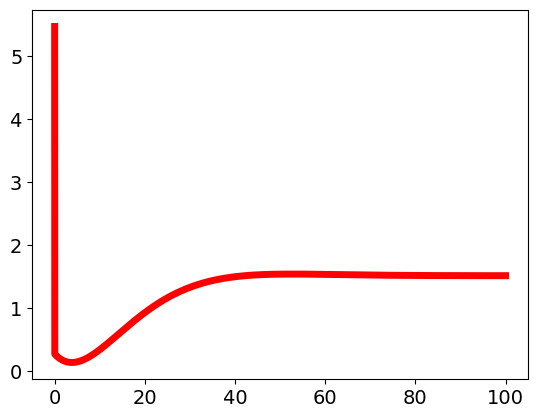

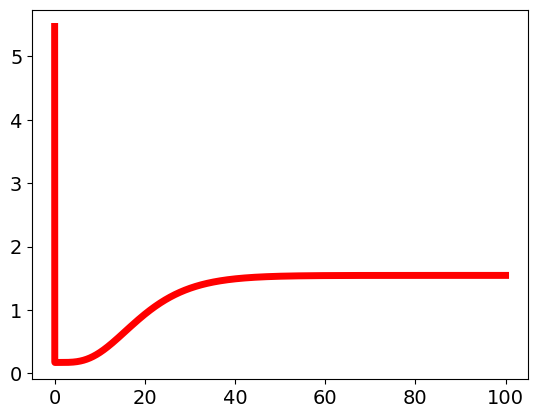

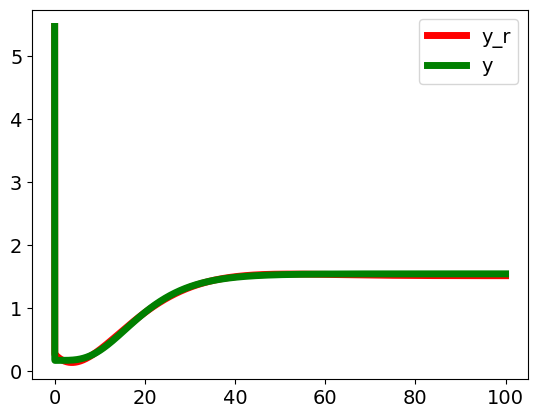

In [61]:
t_ol = np.linspace(0,100,10000)
y_r = step_response(L0_r,T=t_ol)
plt.show()
y = step_response(L0,T=t_ol)
plt.show()
plt.plot(t_ol,y_r,label='y_r')
plt.plot(t_ol,y,label='y')
plt.legend()

# Bode Plots of loop-gain

Phase margin = -111 deg at w = 0.2026, f = 0.03225 Hz, period = 31.01
Gain margin = 0.0953 at f = 0.01449 Hz
$\theta_{pm} = -111^\circ$
$\omega_{pm} = \SI{0.20}{\radian\per\second}$


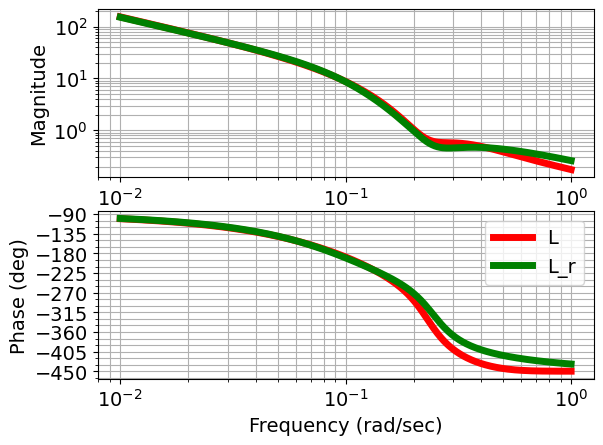

In [62]:
Omega = np.logspace(-2,0,500)
mag,phase,omega = con.bode_plot([L,L_r],omega=Omega)
plt.legend(['L','L_r'])
gm, pm, wcg, wcp = con.margin(L)
print(f'Phase margin = {pm:.0f} deg at w = {wcp:.4f}, f = {wcp/(2*np.pi):.4} Hz, period = {2*np.pi/wcp:0.4}')
print(f'Gain margin = {gm:.4f} at f = {wcg/(2*np.pi):.4} Hz')

print(f'$\\theta_{{pm}} = {round(pm)}^\\circ$')
print(f'$\\omega_{{pm}} = \\SI{{{wcp:.2f}}}{{\\radian\\per\\second}}$')

## Linear closed-loop

In [63]:
Integrator = con.tf(1,[1,0])
CLsys = con.feedback(Integrator,L0)
CLsys_r = con.feedback(Integrator,L0_r)
# CLsys = con.minreal(con.series(F0,CLsys0))
# CLsys_r = con.minreal(con.series(F0_r,CLsys0_r))

con.tf(CLsys_r)
poles = con.poles(CLsys_r)
print(poles)

TransferFunction(array([1.00000000e+00, 5.03993084e+05, 8.27918870e+04, 5.48835210e+03]), array([ 1.00000000e+00,  5.03998553e+05,  2.21439284e+05, -1.09015425e+04,
        8.32811284e+03]))

[-5.03998114e+05+0.j         -5.36958776e-01+0.j
  4.87967143e-02+0.16850036j  4.87967143e-02-0.16850036j]


In [64]:
imag = np.imag(poles[2])
print(imag)
Freq = imag/(2*np.pi)
print(Freq)
print(1/Freq)

0.1685003566224878
0.026817664669216118
37.28885465362298


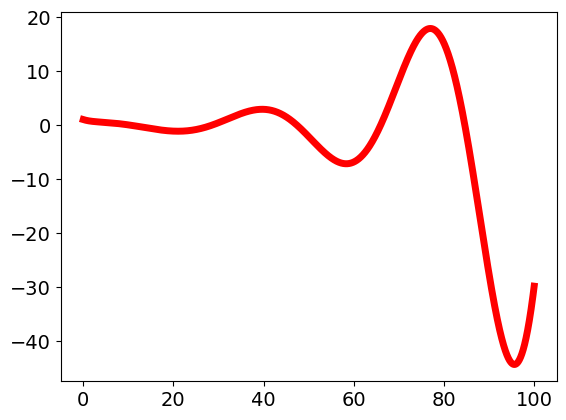

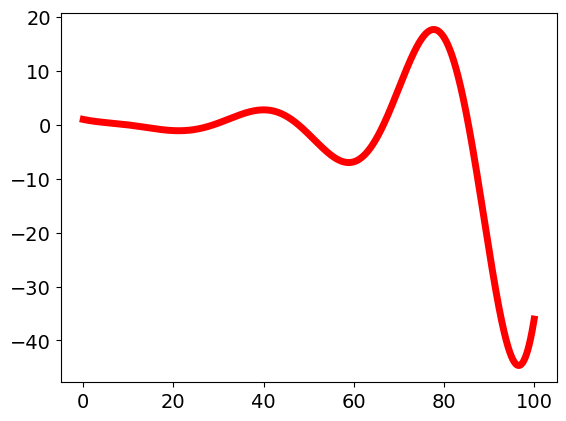

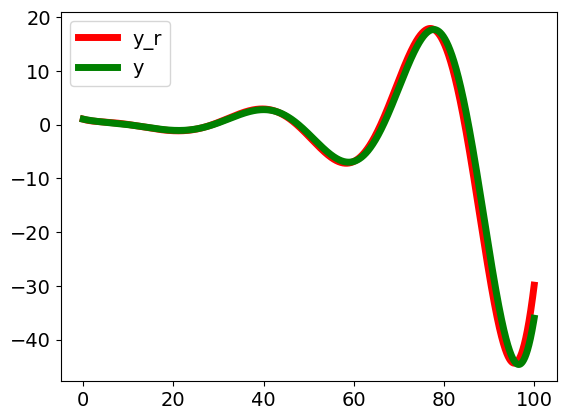

In [65]:
y_r = impulse_response(CLsys_r,T=t_ol)
plt.show()
y = impulse_response(CLsys,T=t_ol)
plt.show()
plt.plot(t_ol,y_r,label='y_r')
plt.plot(t_ol,y,label='y')
plt.legend()

## Non-linear simulation

In [66]:
## Simulate
X0 = copy.copy(x_ss)
pert = 0.1
X0[i3] += pert

# t_sim  =  np.linspace(0,130,10000)
t_sim = t_ol
ndat = st.sim(s,sc=sc,t=t_sim,X0=X0,parameter=parameter,quiet=True)


Text(0.5, 0, '$t$')

Text(0, 0.5, '$x_P-x_{ss}$')

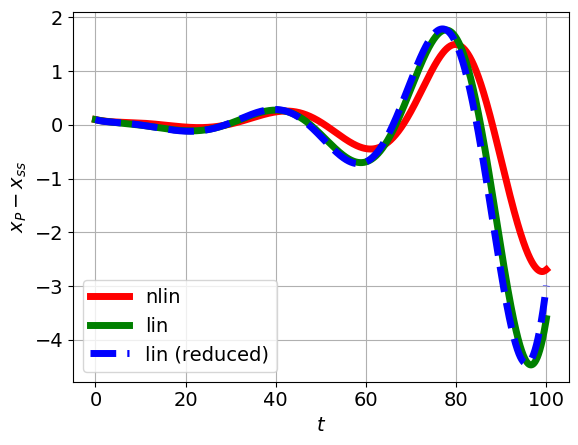

In [67]:
y_n = (ndat['X'][:,i3] - x_ss[i3] )
plt.plot(t_sim,y_n, label='nlin',lw=5)
plt.plot(t_ol,pert*y,label='lin',lw=5)
plt.plot(t_ol,pert*y_r,label='lin (reduced)',lw=5,ls='dashed')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_P-x_{ss}$')
# plt.xlim(right=max(t_ol))
SaveFig(SystemName,'Simulation')

## Period

In [68]:

# i_zc = zero_crossings(y_n)

# t_zc = t_sim[i_zc].T
# T_zc = np.diff(t_zc)
# print(t_zc)
# print(T_zc)

# plt.hlines([1/Freq],min(t_zc),max(t_zc),ls='dashed',color='grey',label='linear')
# plt.plot(t_zc[1:],T_zc, label='actual')

# plt.grid()
# plt.legend()
# plt.xlabel('$t$')
# plt.ylabel('$T$')
# SaveFig(SystemName,'Period')

# # print(zc)
# print(1/Freq)


# Split-loop model

In [69]:
OutpVar = 'P3'
SplitVar = 'P3f'

In [70]:
## Modify orignal list of reactions to insert split-loop variable SplitVar
SLreactions = []
for reac in reactions:
    react = reac[0]
    name = reac[1]
    if '2*P3' in react:
        print(f'Reaction {name} is {react}')
        react = react.replace(OutpVar,SplitVar)
        print(f'Reaction {name} is now {react}')
    SLreactions.append((react,name))
    
SLrn = Reaction_Network(name="RepressilatorSL")
for (reaction_string,reaction_name) in SLreactions:
    # print(reaction_name,reaction_string)
    SLrn.add_reaction(reaction_string, name=reaction_name)
    




Reaction G2_Tc3 is G2_E + 2*P3 = G2_EI
Reaction G2_Tc3 is now G2_E + 2*P3f = G2_EI
Reaction G2_Tc4 is G2_EA + 2*P3 = G2_EAI
Reaction G2_Tc4 is now G2_EA + 2*P3f = G2_EAI


In [71]:
SLs0 = rn2bg(SLrn,'RepressilatorSL_abg')
import RepressilatorSL_abg
imp.reload(RepressilatorSL_abg)

<module 'RepressilatorSL_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Repressilator/RepressilatorSL_abg.py'>

## Stoichiometry

In [72]:
SLs = st.stoich(RepressilatorSL_abg.model(),quiet=True)
species_sl = SLs['species']

In [73]:
for spec in SLs['species']:
    if spec[0]=='P':
        print(spec)

P2
P1
P3f
P3


In [74]:
## Add SplitVar to the OL chemostat list.
SLchemostats = copy.copy(OLchemostats) 
SLchemostats.append(SplitVar)
print(SLchemostats)
SLsc = st.statify(SLs,chemostats=SLchemostats)

['A', 'G1_XM', 'G1_XP', 'G2_XM', 'G2_XP', 'G3_XM', 'G3_XP', 'P3', 'P3f']


In [75]:
## Reactions
disp.Latex(st.sprintrl(SLs,chemformula=False,split=16,all=True))

<IPython.core.display.Latex object>

In [76]:
species_sl = SLs['species']
species = s['species']
# print(len(species_sl),species_sl)

## Steady-state analysis

In [77]:
## Create the steady state corresponding to open loop with x_inh=x_P:S
x_sl_ss = np.ones(SLs['n_X'])
X_ss = copy.copy(x_ss)
for i,spec in enumerate(species):
    # print(spec)
    x_sl_ss[species_sl.index(spec)] = X_ss[i]
x_sl_ss[species_sl.index(SplitVar)] = X_ss[species.index(OutpVar)]

## Make parameters the same
K_out = parameter['K_'+OutpVar]
# print(K_out)
parameter['K_'+SplitVar] = K_out

In [78]:
# for key in parameter:
#     if key in ['K_P3f']:
#         print('****')
#     print(key, parameter[key])

## Linearise

In [79]:
Sys = st.lin(SLs,SLsc,parameter=parameter,x_ss=x_sl_ss,outvar='dX',quiet=True)

In [80]:
Inp = [SplitVar,OutpVar]
Outp = Inp

TF = {}
for inp in Inp:
    for outp in Outp:
        key = inp+'_'+outp
        print(key)
        sys = ExtractSubsystem(Sys,SLchemostats.index(inp),species_sl.index(outp))
        degree = len(sys.B)
        print(degree)
        # maxdegree = 4
        print('gain',con.dcgain(sys))
        if degree>redOrder:
            sys_r = con.balred(sys,redOrder)
        else:
            sys_r = sys
        sys_r = con.minreal(sys_r,tol = 1e-6)
        
        print('gain_r',con.dcgain(sys_r))
        con.tf(sys_r)
        print(con.poles(sys_r))
        TF[key] =   con.tf(sys_r)  

P3f_P3f
39 states have been removed from the model
2
gain -7.202571872255703e-15
0 states have been removed from the model
gain_r 9.202361095361766e-13


TransferFunction(array([-1.01881163e-01, -1.52500680e+09,  3.44903564e+00]), array([1.00000000e+00, 1.49684865e+10, 1.31302260e+12]))

[-1.49684864e+10+0.j -8.77191299e+01+0.j]
P3f_P3
3 states have been removed from the model
38
gain -1.3731107731905767
0 states have been removed from the model
gain_r -1.3875522550223096


TransferFunction(array([-0.00571284,  0.00717425, -0.00364629]), array([1.        , 0.30990685, 0.04980632, 0.00262786]))

[-0.08602848+0.j         -0.11193919+0.13422377j -0.11193919-0.13422377j]
P3_P3f
5 states have been removed from the model
36
gain -7.622218992898018e-17
3 states have been removed from the model
gain_r 0.0


/home/peterg/anaconda3/envs/bgt/lib/python3.8/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/home/peterg/anaconda3/envs/bgt/lib/python3.8/site-packages/scipy/signal/_filter_design.py:1091: RuntimeWarning: invalid value encountered in divide
  b /= b[0]


TransferFunction(array([0.]), array([1.]))

[]
P3_P3
4 states have been removed from the model
37
gain -0.17328680660197282
2 states have been removed from the model
gain_r -0.1732867955062929


TransferFunction(array([-5.36738436e+00, -8.73365469e+04]), array([1.00000000e+00, 5.04000011e+05]))

[-504000.0112114+0.j]


## Active and passive loop gains

In [81]:
# print(f'Gain L0 = {con.dcgain(L0):.2f}')
# L0_pas_P = TF['P_P']
# K =  parameter['K_decr3_A']*parameter['kappa_decr3_r']
# K_f =  parameter['kappa_decr3_rf']
# print(f'Gain L0_pas_P = {con.dcgain(L0_pas_P):0.2f} ({K_f:0.2f})')

In [82]:
LL0 = con.tf(0,1)
for index in TF:
    LL0 = con.parallel(LL0,-TF[index])
    
LL = IntegrateTF(LL0)

LL0_r = con.tf(con.balred(con.ss(LL0),redOrder))
LL_r = IntegrateTF(LL0_r)

## Check the same as derived from OL analysis
print('LL0_r (from open-loop')
con.tf(LL0_r)
print('L0_r (from split-loop)')
con.tf(L0_r)


L0_act = -TF[SplitVar+'_'+OutpVar]
L_act = IntegrateTF(L0_act)
L0_act_r = con.tf(con.balred(con.ss(L0_act),redOrder))
print(f'L0_act_r: ({con.dcgain(L0_act_r):0.2f})')
con.tf(L0_act_r)

L0_pas = con.minreal(con.parallel(-TF[OutpVar+'_'+OutpVar],-TF[SplitVar+'_'+SplitVar]),tol=1e-3)
print('L0_pas')
print(f'L0_pas: ({con.dcgain(L0_pas):0.2f})')
con.tf(L0_pas)
L_pas = IntegrateTF(L0_pas)
# L0_pas_r = con.tf(con.balred(con.ss(L0_pas),redOrder))
# print('L0_pas_r')
# con.tf(L0_pas)

L0_pas_P = con.minreal(-TF[OutpVar+'_'+OutpVar])
L_pas_P = IntegrateTF(L0_pas_P)
# L0_pas_P_r = con.tf(con.balred(con.ss(L0_pas_P),redOrder))
print(f'L0_pas_P: ({con.dcgain(L0_pas_P):0.2f})')
con.tf(L0_pas_P)

L0_pas_Inh = con.minreal(-TF[SplitVar+'_'+SplitVar])
L_pas_Inh = IntegrateTF(L0_pas_Inh)
print(f'L0_pas_Inh: ({con.dcgain(L0_pas_Inh):0.2f})')
con.tf(L0_pas_Inh)

LL0_r (from open-loop


TransferFunction(array([ 5.46926552e+00,  1.38647424e+05, -1.63871563e+04,  8.32857966e+03]), array([1.00000000e+00, 5.03993089e+05, 8.28034493e+04, 5.48998158e+03]))

L0_r (from split-loop)


TransferFunction(array([ 5.46926552e+00,  1.38647397e+05, -1.63898946e+04,  8.32811284e+03]), array([1.00000000e+00, 5.03993084e+05, 8.27918870e+04, 5.48835210e+03]))

L0_act_r: (1.39)


TransferFunction(array([ 0.00571284, -0.00717425,  0.00364629]), array([1.        , 0.30990685, 0.04980632, 0.00262786]))

1 states have been removed from the model
L0_pas
L0_pas: (0.17)


TransferFunction(array([5.46926552e+00, 1.39155476e+05, 7.66108590e+06]), array([1.00000000e+00, 5.04087730e+05, 4.42104425e+07]))

0 states have been removed from the model
L0_pas_P: (0.17)


TransferFunction(array([5.36738436e+00, 8.73365469e+04]), array([1.00000000e+00, 5.04000011e+05]))

1 states have been removed from the model
L0_pas_Inh: (-0.00)


TransferFunction(array([ 1.01881163e-01, -2.30419801e-10]), array([ 1.        , 87.71912993]))

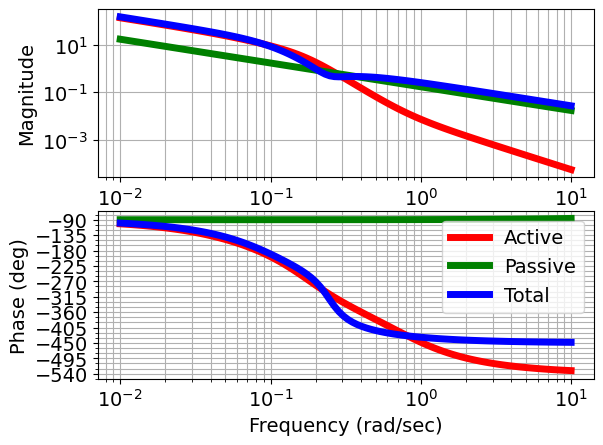

In [83]:
L_list = [L_act,L_pas,LL_r]
Omega = np.logspace(-2,1,100)
mag,phase,om=con.bode_plot(L_list,omega=Omega)
plt.legend(['Active','Passive','Total','Reduced'])
# SaveFig(SystemName,'SplitBode')

In [84]:
## Margins
gm, pm, wcg, wcp = con.margin(LL_r)
print(pm,wcp)

-89.798689160331 0.19851803296821272


## Nichols plots

In [85]:
# ## Nichols
# con.nichols_plot(L_list,omega)
# plt.legend(['Active','Passive','Total'])
# SaveFig(SystemName,'SplitNichols')

## Root Locus

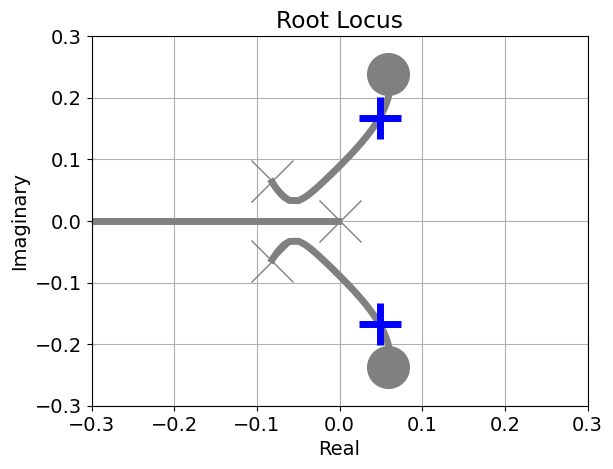

In [86]:
xlim=(-0.3,0.3)
ylim=(-0.3,0.3)
kvect = np.logspace(-3,1,100)
# roots1,gains1 = con.root_locus(L_r,kvect=[1],plot=False)
# roots,gains=con.root_locus(L_r,kvect=kvect,xlim=xlim,ylim=ylim,grid=False)
# plt.plot(np.real(roots1),np.imag(roots1),color='red', marker='+', linestyle='dashed',markersize=16)
# plt.grid()
# SetPlot(RL=True)
# SaveFig(SystemName,'SplitRootLocus',RL=True)
# SetPlot()

SetPlot(RL=True)
roots1,gains1 = con.root_locus(L,kvect=[1],plot=False)
roots,gains=con.root_locus(L_r,kvect=kvect,xlim=xlim,ylim=ylim,grid=False)
plt.plot(np.real(roots1),np.imag(roots1),color='b', marker='+',mew=5)
plt.grid()
SaveFig(SystemName,'SplitRootLocus',RL=True)
SetPlot()

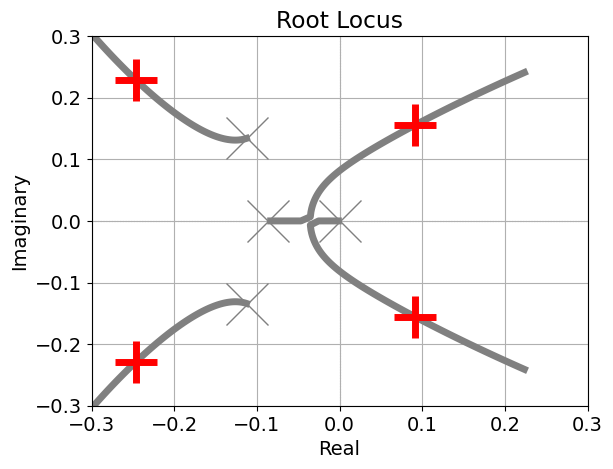

In [87]:
xlim=(-0.3,0.3)
ylim=(-0.3,0.3)
kvect = np.logspace(-3,1,100)
# roots1,gains1 = con.root_locus(L_act,kvect=[1],plot=False)
# roots,gains=con.root_locus(L_act,kvect=kvect,xlim=xlim,ylim=ylim,grid=False)
# plt.plot(np.real(roots1),np.imag(roots1),color='red', marker='+', linestyle='dashed',markersize=16)
# plt.grid()
# SetPlot(RL=True)
# SaveFig(SystemName,'SplitRootLocus_act',RL=True)
# SetPlot()

SetPlot(RL=True)
roots1,gains1 = con.root_locus(L_act,kvect=[1],plot=False)
roots,gains=con.root_locus(L_act,kvect=kvect,xlim=xlim,ylim=ylim,grid=False)
plt.plot(np.real(roots1),np.imag(roots1),color='r', marker='+',mew=5)
plt.grid()
SaveFig(SystemName,'SplitRootLocus_act',RL=True)
SetPlot()

## Sisotool

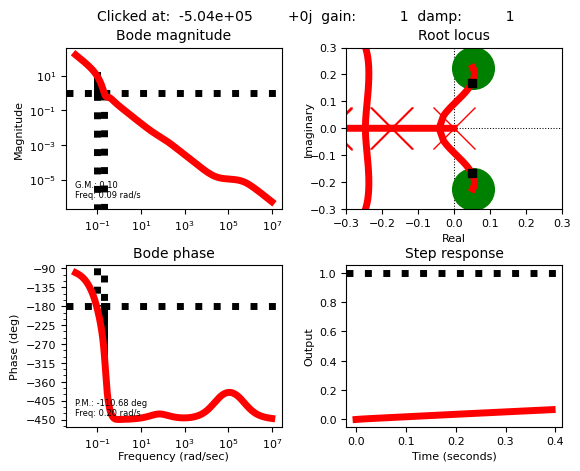

In [88]:
con.sisotool(L,xlim_rlocus=xlim,ylim_rlocus=ylim)

## Bode (replotted)

Text(0.5, 0, '$\\omega$ rad/sec ($\\omega_c = 0.20$)')

Text(0, 0.5, '$|L|$')

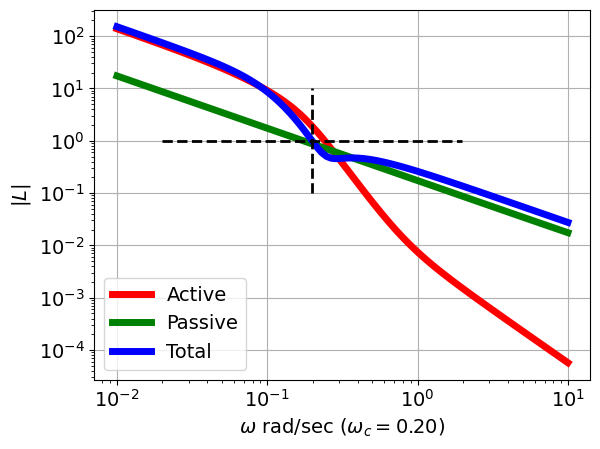

In [89]:
Name = ['Active','Passive','Total','Reduced']
# Omega = np.logspace(-2,0)
for i,l in enumerate(L_list):
#     print(i,l)
    mag,phase,omega = con.bode_plot(l,omega=Omega,plot=False)
    plt.loglog(omega,mag,label=Name[i])
# plt.hlines(1,min(omega),max(omega),ls='dashed',color='black',label='Unit gain')
plt.hlines(1,wcp/10,wcp*10,ls='dashed',color='black',lw=2)  
plt.vlines(wcp,0.1,10,ls='dashed',color='black',lw=2)
plt.legend(loc='lower left')
# plt.legend()
plt.grid()
# plt.xlabel(r'$\omega$')
# print(f'{wcp:.2f}')
# print(f'$\\omega$ rad/sec ($\\omega_c = {int(wcp)}$)')
plt.xlabel(f'$\\omega$ rad/sec ($\\omega_c = {wcp:.2f}$)')
plt.ylabel(r'$|L|$')
SaveFig(SystemName,'SplitBodeMag')

-90


Text(0.5, 0, '$\\omega$ rad/sec ($\\theta_{pm} = -90^\\circ$)')

Text(0, 0.5, '$\\angle{L}$')

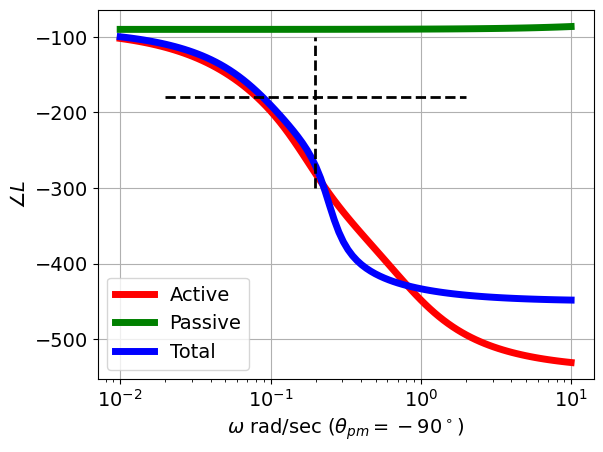

In [90]:
for i,l in enumerate(L_list):
#     print(i,l)
    mag,phase,omega= con.bode_plot(l,omega=Omega,plot=False)
    plt.semilogx(omega,phase*180/np.pi,label=Name[i])
plt.legend()
# plt.hlines(-180,min(omega),max(omega),ls='dashed',color='black')
plt.hlines(-180,wcp/10,wcp*10,ls='dashed',color='black',lw=2)  
plt.vlines(wcp,-300,-100,ls='dashed',color='black',lw=2)
# plt.xlabel(r'$\omega$')
print(f'{pm:.0f}')
plt.xlabel(f'$\\omega$ rad/sec ($\\theta_{{pm}} = {pm:.0f}^\circ$)')
plt.ylabel(r'$\angle{L}$')
plt.grid()
SaveFig(SystemName,'SplitBodePha')

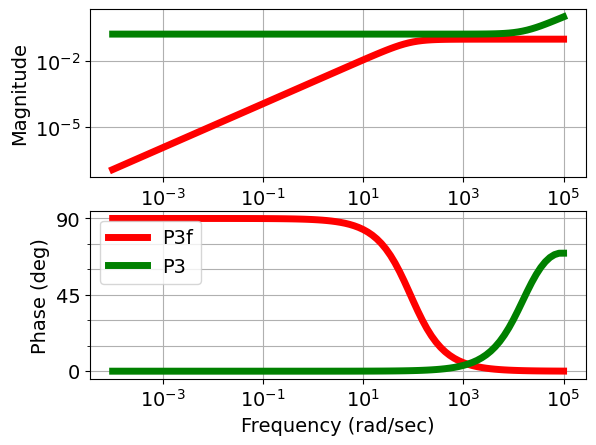

In [91]:
L_list = [L0_pas_Inh,L0_pas_P]
Omega = np.logspace(-4,5,100)
mag,phase,om=con.bode_plot(L_list,omega=Omega,initial_phase=90)
plt.legend(['P3f','P3'])
# SaveFig(SystemName,'SplitBode')

2

(-2.0, 1.0)

(-1.0, 1.0)

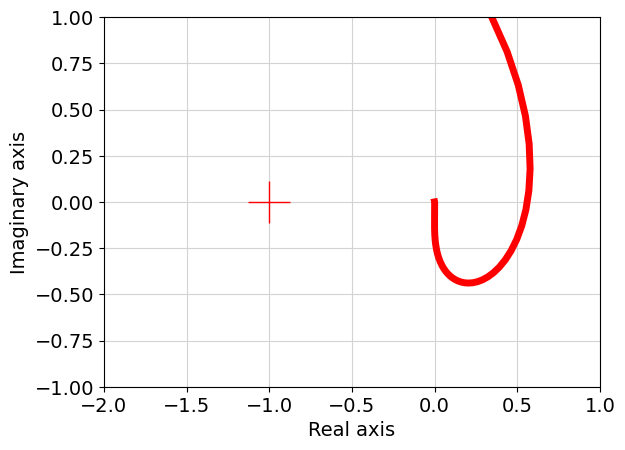

In [92]:
con.nyquist_plot([LL],mirror_style=False)
plt.xlim(-2,1)
plt.ylim(-1,1)


[2, 0]

(-3.0, 0.5)

(-2.0, 2.0)

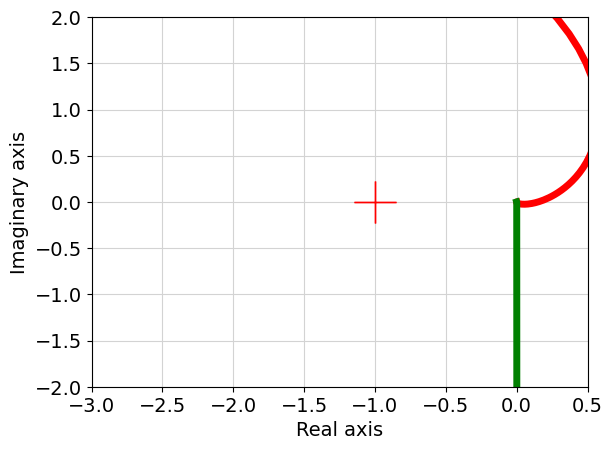

In [93]:
con.nyquist_plot([L_act,L_pas],mirror_style=False)
plt.xlim(-3,0.5)
plt.ylim(-2,2)


In [94]:
con.tf(L0_r)
con.tf(con.balred(L0_r,2))

TransferFunction(array([ 5.46926552e+00,  1.38647397e+05, -1.63898946e+04,  8.32811284e+03]), array([1.00000000e+00, 5.03993084e+05, 8.27918870e+04, 5.48835210e+03]))

TransferFunction(array([5.46926552e+00, 1.38646157e+05, 1.75618084e+04]), array([1.00000000e+00, 5.03992822e+05, 7.82131216e+03]))